In [16]:
import os
import os.path as path
import re
from enum import Enum
from functools import total_ordering

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.contrast import ContrastResults
from scipy.stats import chi2

from pymer4.models import Lm2, Lmer

from tqdm.notebook import tqdm

```
Collision ~ Condition + ( 1 | Time_Taken ) + ( 1 | Head_Movement ) + ( 1 | Reported_Comfort ) + ( 1 | Reported_Tiredness ) + ( 1 | Reported_NavQuality) 
+ ( 1 | Block ) + ( 1 | Controller Familiarity ) + ( 1 | VR Familiarty ) + ( 1 | Gender ) + ( 1 | Sex@Birth ) + (1 | Height ) + ( 1 | Age ) + ( 1 | Subject )
```

DF: stack block 2+3
46 x 17

[ Condition ; **CrashCount ; StrafeCount ; TimeTaken ; TotalHeadMovement** ; Block ; Glasses/Contacts ; Hallway ; ControllerFamiliarity ; VRFamiliarity ; Gender ; Sex@Birth ; Height ; Age ; Subject ]

Qualitative analysis only:
RepComfort ; RepTired ; RepNavQuality

In [2]:
subjPattern = re.compile(r"^\d+$")
trialPattern = re.compile(r"^(?P<block>\d\d)_(?P<trial>\d\d)(?P<data>\w+)\.tsv$")

ID01 = "00"
ID02 = "01"
ID03 = "02"
IDENTS = [ID01, ID02, ID03]

subjects = sorted([d for d in os.listdir() if subjPattern.match(d)])
print(', '.join(subjects))

def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", path.join(subjId, file))
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

def load_csv(filepath:str=None, subject:str=None, file:str=None) -> pd.DataFrame:
    if filepath is None:
        filepath = path.join(subject, file)
    df = pd.read_csv(filepath, sep='\t', usecols=lambda c: not c.startswith('Unnamed:'))
    return df

@total_ordering
class Boxes(Enum):
    NoBox  = 0
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    def __int__(self):
        return self.value

@total_ordering
class Collisions(Enum):
    no = 0
    bump = 1
    strafe = 2
    crash = 5

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 023


In [3]:
participant_survey_file = './participant_survey.csv'
column_mapping = {
    'Subject Information [Subject ID]' : "SubjectId",
    'Do you feel like you had enough training time with the simulated phosphene vision and the different conditions?  Use the comment box to add an explanation / details. ' : "EnoughTraining",
    'Do you feel like you had enough training time with the simulated phosphene vision and the different conditions?  Use the comment box to add an explanation / details.  [Comment]' : "EnoughTrainingComment",
    'Did you feel like you were still getting better throughout the trials in interpreting the simulated phosphene vision?  Use the comment box to add an explanation / details. ' : "ImprovedThroughoutBlocks",
    'Did you feel like you were still getting better throughout the trials in interpreting the simulated phosphene vision?  Use the comment box to add an explanation / details.  [Comment]' : "ImprovedThroughoutBlocksComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [relied on hands for specific parts (which?)]' : "StrategyHands",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [relied on hands for specific parts (which?)][Comment]' : "StrategyHandsComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [exaggerated or rhythmic head movements]' : "StrategyHeadMovement",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [exaggerated or rhythmic head movements][Comment]' : "StrategyHeadMovementComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating depth by moving sideways]' : "StrategySidewayMovement",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating depth by moving sideways][Comment]' : "StrategySidewayMovementComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating boundaries with the center most pixels/phosphenes]' : "StrategyCenterFocus",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating boundaries with the center most pixels/phosphenes][Comment]' : "StrategyCenterFocusComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating boundaries with the outer/peripheral pixels/phosphenes]' : "StrategyPeripheralFocus",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [estimating boundaries with the outer/peripheral pixels/phosphenes][Comment]' : "StrategyPeripheralFocusComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [ sticking to the walls]' : "StrategyWalls",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [ sticking to the walls][Comment]' : "StrategyWallsComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [ moving straight-forward with as little sideway movement as possible]' : "StrategyForwardFirst",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [ moving straight-forward with as little sideway movement as possible][Comment]' : "StrategyForwardFirstComment",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [Other]' : "StrategyOther",
    'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [Other comment]' : "StrategyOtherComment",
    'Did your strategies change throughout the experiment? If so, can you explain why? ' : "StrategyChange",
    'Did your strategies change throughout the experiment? If so, can you explain why?  [Comment]' : "StrategyChangeComment",
    'How used to / comfortable with using controllers are you? With a 1 being unfamiliar with controllers and 5 being controllers feeling natural to use to you.' : "ControllerFamiliarity",
    'How often have you used a virtual reality headset before? (e.g. HTC Vive, Oculus Quest, Google Cardboard, Oculus Rift, ...)' : "VRUsage",
    'Did you ever use the HTC Vive Wands (the controllers used in the experiment before)?' : "ViveWandExp",
    'Do you experience motion sickness regularly? (e.g. on the bus / train, while driving, in other VR environments, ...)' : "MotionSick",
    'Did you participate in any phosphene vision experiment or demo before?' : "PhospheneExp",
    'How old are you?' : "Age",
    'What sex were you assigned at birth / what is on your birth certificate?' : "Sex",
    'Pick the gender identity that best describes you currently' : "Gender",
    'How tall are you? (in cm)' : "Height"
}

surv_df = pd.read_csv(participant_survey_file, sep='\t')
surv_df = surv_df.rename(columns=column_mapping)
surv_df = surv_df.set_index("SubjectId")

block_eval_file = './block_eval_survey.csv'
column_mapping = {
    'Block Information [Block ID]' : "Block",
    'Block Information [Subject ID]' : 'SubjectId',
    'Order in which conditions occured [Rank 1]' : "1stCondition",
    'Order in which conditions occured [Rank 2]' : "2ndCondition",
    'Order in which conditions occured [Rank 3]' : "3rdCondition",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [1st trial / condition of this block]' : "1stNavRating",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [2nd trial / condition of this block]' : "2ndNavRating",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [3rd trial / condition of this block]' : "3rdNavRating",
    'Which condition do you think you performed best in?' : "BestCondition",
    'Select all conditions that you experienced nausea or motion sickness in. [1st trial / condition of this block]' : "1stNausea",
    'Select all conditions that you experienced nausea or motion sickness in. [2nd trial / condition of this block]' : "2ndNausea",
    'Select all conditions that you experienced nausea or motion sickness in. [3rd trial / condition of this block]' : "3rdNausea",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 1]' : "1stTiring",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 2]' : "2ndTiring",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 3]' : "3rdTiring",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 1]' : "1stComfort",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 2]' : "2ndComfort",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 3]' : "3rdComfort",
    'Mark how much you feel the statement applies to you right now. [I feel tired / distracted]' : "Tired_Distracted",
    'Mark how much you feel the statement applies to you right now. [I can concentrate]' : "Concentration",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 1]' : "1stConditionSubj",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 2]' : "2ndConditionSubj",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 3]' : "3rdConditionSubj",
    'Anything else you would like to note about this block? (e.g. technical issues, notable pysical or emotional reactions, anything you would have liked to add to the previous questions, ...)' : "Comments"
}

eval_df = pd.read_csv(block_eval_file, sep='\t')
eval_df = eval_df.rename(columns=column_mapping)
eval_df.set_index(['SubjectId', 'Block'], inplace=True)
eval_df = eval_df.replace(to_replace = {"Condition A (eye movement ignored)" : "G.Ignored",
                    "Condition B (locked to your focus point)" : "G.Locked",
                    "Condition C (eye movement to scan the scene)" : "G.Asissted",
                    "Gaze Ignored" : "G.Ignored",
                    "Gaze Locked" : "G.Locked",
                    "Gaze Asissted" : "G.Asissted" })

In [4]:
dfColl = pd.read_hdf('data.h5', key='collisions')
### group continuous collisions and overwrite with highest collision type
# find transitions between collisions
collGroups = dfColl.loc[dfColl['collision'].shift() != dfColl['collision']].copy()
# count no collision as group ID
collGroups['CollisionGroup'] = (collGroups['collision'] == Collisions.no).cumsum()
# selecet highest severity collision
collClass = collGroups.groupby('CollisionGroup')['collision'].max()
# overwrite whole group with highest severity collision
collGroups.collision = collGroups.apply(lambda r: Collisions.no if r.collision == Collisions.no else collClass.loc[r.CollisionGroup], axis=1)

# merge with original dataframe and fill group with highest severity collision
dfColl['GroupedCollision'] = collGroups.reindex(dfColl.index)['collision'].ffill()

In [5]:
dfHeadMove = pd.read_hdf('data.h5', key='headmovement')
summed = dfHeadMove.groupby(dfHeadMove.index.names[:-1]).sum()
zscoredHeadMove = []
absoluteHeadMove = []
for subj in subjects:
    s = summed.loc[subj, :, :, :]
    zscored = s.apply(lambda c: (c - c.mean()) / c.std() if c.name[1].startswith('d') else c, axis=0)
    zscoredHeadMove.append(zscored)
    absoluteHeadMove.append(s)

zscoredHeadMove = pd.concat(zscoredHeadMove, axis=0, keys=subjects)
absoluteHeadMove = pd.concat(absoluteHeadMove, axis=0, keys=subjects)

In [6]:
def create_dataset(load_first_block = False, zscore_headmovement=False, constrain_trial_to_obstacle_segments=True):
    dfColl.sort_index(inplace=True)
    rows = []

    for subj in tqdm(subjects):
        file_mapping = load_subject(subj)
        for block in IDENTS if load_first_block else [ID02, ID03]:
            for trial in IDENTS:
                files = file_mapping[block][trial]
                files = sorted(files)
                dfCfg = load_csv(subject=subj, file=files[-1])

                condition = dfCfg.loc[0, 'GazeCondition']
                hallway = dfCfg.loc[0, 'Hallway'][-1]
                glasses = dfCfg.loc[0, 'Glasses']

                coll_cond = "G.Ignored" if condition == "GazeIgnored" else "G.Locked" if condition == "SimulationFixedToGaze" else "G.Assisted"
                subj_coll = dfColl.loc[block, coll_cond, int(hallway)-1, subj]
                if constrain_trial_to_obstacle_segments:
                    subj_coll = subj_coll[(subj_coll.x >= 4) & (subj_coll.x <= 42)]

                collCounts = subj_coll[subj_coll.GroupedCollision != Collisions.no][['CollisionGroup','GroupedCollision']].drop_duplicates()['GroupedCollision'].value_counts()
                crash_count = collCounts.loc[Collisions.crash] if Collisions.crash in collCounts.index else 0
                strafe_count = collCounts.loc[Collisions.strafe] if Collisions.strafe in collCounts.index else 0
                time_taken = subj_coll['seconds'].max()

                headmovement_dat = zscoredHeadMove.loc[subj, block, coll_cond] if zscore_headmovement else absoluteHeadMove.loc[subj, block, coll_cond] / time_taken
                headmovement = headmovement_dat[('Head', 'dMove')] #+ headmovement_dat[('Head', 'dAngle')]

                eyemovement = 0

                surv = surv_df.loc[int(subj)]
                controllerfamiliarity = surv['ControllerFamiliarity']
                VRfamiliarity = surv['VRUsage']
                gender = surv['Gender']
                sex = surv['Sex']
                height = surv['Height']
                age = surv['Age']
                rows.append((
                    condition               , # condition
                    crash_count             , #  CrashCount
                    strafe_count            , # StrafeCount
                    time_taken              , # TimeTaken
                    headmovement            , # TotalHeadMovement
                    eyemovement             , # Eye Movement total
                    block                   , # Block
                    glasses                 , # Glasses/Contacts
                    hallway                 , # Hallway
                    controllerfamiliarity   , # ControllerFamiliarity
                    VRfamiliarity           , # VRFamiliarity
                    gender                  , # Gender
                    sex                     , # Sex@Birth
                    height                  , # Height
                    age                     , # Age
                    subj                      # Subject
                ))

    dataset = pd.DataFrame(np.array(rows), columns=['Condition', 'CrashCount', 'StrafeCount', 'TimeTaken', 'TotalHeadMovement', 'TotalEyeMovement', 'Block', 'VisionAid', 'Hallway', 'ControllerFamiliarity', 'VRFamiliarity', 'Gender', 'Sex', 'Height', 'Age', 'Subject'])

    dtyping = {
        'Condition' : 'category',
        'CrashCount' : int,
        'StrafeCount' : int,
        'TimeTaken' : float,
        'TotalHeadMovement' : float,
        'TotalEyeMovement' : float,
        'Block' : 'category',
        'VisionAid' : 'category',
        'Hallway' : 'category',
        'ControllerFamiliarity' : 'category',
        'VRFamiliarity' : 'category',
        'Gender' : 'category',
        'Sex' : 'category',
        'Height' : float,
        'Age' : int,
        'Subject' : 'category'
    }
    for k, v in dtyping.items():
        dataset[k] = dataset[k].astype(v)

    return dataset

In [62]:
try:
    raise ValueError('Out of date')
    dataset = pd.read_hdf('data.h5', key='dataset')
    print("Loaded dataset from disk")
except (KeyError, FileNotFoundError, ValueError) as e:
    print("Failed to load dataset from disk, creating new one")
    dataset_allblocks = create_dataset(
        load_first_block=True,
        zscore_headmovement=False,
        constrain_trial_to_obstacle_segments=True)
    dataset = create_dataset(
        load_first_block=False,
        zscore_headmovement=False,
        constrain_trial_to_obstacle_segments=True)
    dataset.to_hdf('data.h5', key='dataset', complevel=7, format='table')

dataset.head(15)

Failed to load dataset from disk, creating new one


  0%|          | 0/23 [00:00<?, ?it/s]

Error! 018/01_02EngineDataRecord.tsv.bckp
Error! 021/01_02EngineDataRecord.tsv.bckp
Error! 023/01_01SingleEyeDataRecordR.tsv.bckp


  0%|          | 0/23 [00:00<?, ?it/s]

Error! 018/01_02EngineDataRecord.tsv.bckp
Error! 021/01_02EngineDataRecord.tsv.bckp
Error! 023/01_01SingleEyeDataRecordR.tsv.bckp


,Condition,CrashCount,StrafeCount,TimeTaken,TotalHeadMovement,TotalEyeMovement,Block,VisionAid,Hallway,ControllerFamiliarity,VRFamiliarity,Gender,Sex,Height,Age,Subject
0,GazeIgnored,4,4,104.942092,0.039674,0.0,01,None,3,2,0,Woman,Female,171.0,25,001
1,SimulationFixedToGaze,4,3,102.300905,0.039632,0.0,01,None,1,2,0,Woman,Female,171.0,25,001
2,GazeAssistedSampling,4,2,59.331581,0.032484,0.0,01,None,2,2,0,Woman,Female,171.0,25,001
3,GazeAssistedSampling,7,2,58.120561,0.028695,0.0,02,None,3,2,0,Woman,Female,171.0,25,001
4,SimulationFixedToGaze,8,3,57.533842,0.031628,0.0,02,None,2,2,0,Woman,Female,171.0,25,001
5,GazeIgnored,15,1,119.913376,0.036576,0.0,02,None,1,2,0,Woman,Female,171.0,25,001
6,GazeIgnored,8,1,119.268343,0.060308,0.0,01,None,3,2,1,Woman,Female,162.0,23,002
7,SimulationFixedToGaze,6,4,122.993731,0.058176,0.0,01,None,1,2,1,Woman,Female,162.0,23,002
8,GazeAssistedSampling,7,2,116.077203,0.030063,0.0,01,None,2,2,1,Woman,Female,162.0,23,002
9,SimulationFixedToGaze,4,1,137.224484,0.053671,0.0,02,None,3,2,1,Woman,Female,162.0,23,002


In [23]:
# dummied = dataset.replace(to_replace={"Genderqueer / Non-Binary":"Genderqueer", "Prefer not to say":"NoAnswer"})
# dummied['VRFamiliarity'] = dummied['VRFamiliarity'].replace(to_replace={ "0":"None", "1":"Once", "2 - 10":"Some", "10 - 50":"Much"})
# # dummied = pd.get_dummies(dummied, columns=['Condition', 'Block', ])

# print(*dummied.columns, sep=' || ')

In [74]:
# vars_of_interest = ["CrashCount", "StrafeCount", "TimeTaken", "TotalHeadMovement"]
# effect_formula = "+ 1"#+ Block + VisionAid + Hallway + ControllerFamiliarity + VRFamiliarity + Gender + Sex + Height + Age + Subject"
# var2model = dict()

# for idx, var in enumerate(vars_of_interest):
#     formula = f"{var} ~ " + " + ".join(vars_of_interest[:idx] + vars_of_interest[idx+1:]) + effect_formula
#     model = Lm2(formula, data=dataset, group="Condition")

#     var2model[var] = model

#     print("="*25, var, "="*25)
#     print(model.fit())
#     print(model.fixef)
#     break

formula = (
    "TimeTaken ~ -1 + Condition + Block + TotalHeadMovement + (1|Subject)"
)
model = Lmer(formula, data=dataset)
print(model.fit())
# print(model.fixef)

Formula: TimeTaken~-1+Condition+Block+TotalHeadMovement+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 138	 Groups: {'Subject': 23.0}

Log-likelihood: -707.988 	 AIC: 1415.976

Random effects:

                 Name       Var     Std
Subject   (Intercept)  2173.393  46.620
Residual               1433.761  37.865

No random effect correlations specified

Fixed effects:

                                Estimate   2.5_ci  97.5_ci      SE       DF  \
ConditionGazeAssistedSampling    116.208   93.285  139.131  11.696   36.746   
ConditionGazeIgnored             117.441   94.564  140.317  11.672   36.471   
ConditionSimulationFixedToGaze   144.601  121.577  167.626  11.747   37.347   
Block02                          -19.887  -32.585   -7.190   6.478  111.000   
TotalHeadMovement                  1.722   -1.983    5.427   1.890  111.000   

                                T-stat  P-val  Sig  
ConditionGazeAssistedSampling    9.936  0.000  ***  
ConditionGazeIgn

In [63]:
def adjust_bonferroni_holm(contrasts):
    N = contrasts.pvalue.shape[0]
    c = np.arange(1, N+1, 1)
    i = np.argsort(contrasts.pvalue)[::-1]
    
    return np.clip(contrasts.pvalue * c[i], 0, 1)

def get_icc(results):
    '''get the Intraclass Correlation Coefficient (ICC)'''
    icc = results.cov_re / (results.cov_re + results.scale)
    
    return icc.values[0, 0]

conds = sorted(dataset['Condition'].unique())

In [74]:
data = dataset.loc[dataset.Block != ID01]
md = smf.mixedlm("TimeTaken ~ 0 + Condition + Block + CrashCount + StrafeCount", data, groups=data["Subject"])
mdf = md.fit()
print(mdf.summary())
print("ICC: ", get_icc(mdf))
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,0,0], [0,1,-1,0,0,0], [1,0,-1,0,0,0]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary(xname=['Ass|Ign', 'Ign|Lck', 'Ass|Lck']))

                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         TimeTaken
No. Observations:         138             Method:                     REML     
No. Groups:               23              Scale:                      575.0955 
Min. group size:          6               Log-Likelihood:             -647.2040
Max. group size:          6               Converged:                  Yes      
Mean group size:          6.0                                                  
-------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Condition[GazeAssistedSampling]    69.898   11.733  5.957 0.000  46.901  92.895
Condition[GazeIgnored]             73.043   11.919  6.128 0.000  49.683  96.403
Condition[SimulationFixedToGaze]   90.486   11.641  7.773 0.0

In [66]:
for model in [
    "TimeTaken ~ 0 + Block + Condition + TotalHeadMovement",
    "TotalHeadMovement ~ 0 + Block + Condition + TimeTaken",
    "StrafeCount ~ 0 + Block + Condition + TotalHeadMovement",
    "CrashCount ~ 0 + Block + Condition + TotalHeadMovement" ]:
    md = smf.mixedlm(model, dataset_allblocks, groups=dataset_allblocks['Subject'])
    mdf = md.fit()
    contrasts = mdf.t_test(np.array([[1,-1,0,0,0,0], [0,1,-1,0,0,0], [1,0,-1,0,0,0]]), use_t=True)
    contrasts.pvalue = adjust_bonferroni_holm(contrasts)
    print(contrasts.summary(xname=['0 | 1', '1 | 2', '0 | 2'], title=model.split('~')[0].strip()))
    print("ICC: ", get_icc(mdf))

                                  TimeTaken                                   
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0 | 1         21.1572      5.947      3.558      0.001       9.431      32.883
1 | 2         10.8663      5.975      1.819      0.070      -0.914      22.647
0 | 2         32.0236      6.030      5.310      0.000      20.133      43.914
ICC:  0.5739060965280603


/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              TotalHeadMovement                               
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0 | 1         -0.0314      0.042     -0.742      0.459      -0.115       0.052
1 | 2         -0.0627      0.042     -1.503      0.269      -0.145       0.020
0 | 2         -0.0941      0.043     -2.170      0.094      -0.180      -0.009
ICC:  0.08776307808734625


/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                                 StrafeCount                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0 | 1          0.1002      0.308      0.325      0.746      -0.508       0.708
1 | 2          0.3890      0.309      1.257      0.420      -0.221       0.999
0 | 2          0.4892      0.312      1.568      0.355      -0.126       1.104
ICC:  3.539513666252552e-05
                                  CrashCount                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0 | 1          0.1833      0.312      0.587      0.558      -0.433       0.799
1 | 2         -0.3833      0.314     -1.222      0.670      -1.002       0.235
0 | 2         -0.2000      0.317     -0.632      1.000      -0.824       0.424
ICC:  0.2152175119150008

/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.047336
  warnings.warn(msg, ConvergenceWarning)
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     TotalHeadMovement
No. Observations:     138         Method:                 REML             
No. Groups:           23          Scale:                  0.0845           
Min. group size:      6           Log-Likelihood:         -41.4520         
Max. group size:      6           Converged:              Yes              
Mean group size:      6.0                                                  
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Condition[GazeAssistedSampling]   0.163    0.081  2.025 0.043  0.005  0.321
Condition[GazeIgnored]            0.136    0.081  1.683 0.092 -0.022  0.294
Condition[SimulationFixedToGaze]  0.136    0.081  1.684 0.092 -0.022  0.294
Block[T.02]                    

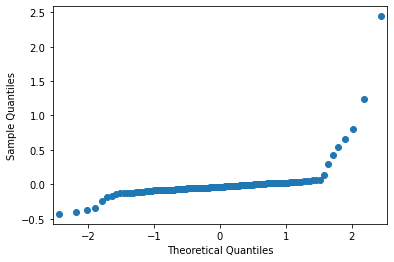

In [178]:
md = smf.mixedlm("TotalHeadMovement ~ -1 + Condition + Block + VisionAid", dataset, groups=dataset["Subject"])
mdf = md.fit()
print(mdf.summary())
print("ICC: ", get_icc(mdf))
sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,0,0], [0,1,-1,0,0,0], [1,0,-1,0,0,0]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary(xname=['Ass|Ign', 'Ign|Lck', 'Ass|Lck']))

In [179]:
md = smf.mixedlm("StrafeCount ~ -1 + Condition + Block + TotalHeadMovement", dataset, groups=dataset["Subject"])
mdf = md.fit()
print(mdf.summary())
print("ICC: ", get_icc(mdf))
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,0,], [0,1,-1,0,0,], [1,0,-1,0,0,]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary(xname=['Ass|Ign', 'Ign|Lck', 'Ass|Lck']))

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       StrafeCount
No. Observations:       138           Method:                   REML       
No. Groups:             23            Scale:                    3.5416     
Min. group size:        6             Log-Likelihood:           -281.6104  
Max. group size:        6             Converged:                Yes        
Mean group size:        6.0                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Condition[GazeAssistedSampling]   2.550    0.325  7.855 0.000  1.914  3.186
Condition[GazeIgnored]            2.722    0.323  8.438 0.000  2.090  3.354
Condition[SimulationFixedToGaze]  3.092    0.323  9.584 0.000  2.459  3.724
Block[T.02]                    

/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [180]:
md = smf.mixedlm("CrashCount ~ -1 + Condition + Block", dataset, groups=dataset["Subject"])
mdf = md.fit()
print(mdf.summary())
print("ICC: ", get_icc(mdf))
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,], [0,1,-1,0,], [1,0,-1,0,]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary(xname=['Ass|Ign', 'Ign|Lck', 'Ass|Lck']))

/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       CrashCount
No. Observations:       138           Method:                   REML      
No. Groups:             23            Scale:                    3.5722    
Min. group size:        6             Log-Likelihood:           -290.4905 
Max. group size:        6             Converged:                Yes       
Mean group size:        6.0                                               
--------------------------------------------------------------------------
                                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Condition[GazeAssistedSampling]  6.152    0.359 17.128 0.000  5.448  6.856
Condition[GazeIgnored]           6.261    0.359 17.431 0.000  5.557  6.965
Condition[SimulationFixedToGaze] 5.674    0.359 15.797 0.000  4.970  6.378
Block[T.02]                      0.348    0.

In [119]:
dfBySubj = eval_df.drop(columns=['1stCondition', '2ndCondition', '3rdCondition'])\
                .rename(columns={'1stConditionSubj' : '1stCondition', '2ndConditionSubj' : '2ndCondition', '3rdConditionSubj':'3rdCondition'})\
                .reset_index()\
                .apply(lambda row: row.replace(to_replace={
                    "1st trial / condition of this block" : row['1stCondition'],
                    "2nd trial / condition of this block" : row['2ndCondition'],
                    "3rd trial / condition of this block" : row['3rdCondition']
                }), axis=1)\
                .set_index(['SubjectId', 'Block'])
dfByTrial = eval_df.reset_index()\
                .apply(lambda row: row.replace(to_replace={
                    "1st trial / condition of this block" : row['1stCondition'],
                    "2nd trial / condition of this block" : row['2ndCondition'],
                    "3rd trial / condition of this block" : row['3rdCondition']
                }), axis=1)\
                .set_index(['SubjectId', 'Block'])

dfNoWrong = eval_df[(eval_df[["1stCondition", "2ndCondition", "3rdCondition"]].values == eval_df[["1stConditionSubj", "2ndConditionSubj", "3rdConditionSubj"]].values).all(axis=1)]\
            .reset_index()\
            .apply(lambda row: row.replace(to_replace={
                "1st trial / condition of this block" : row['1stCondition'],
                "2nd trial / condition of this block" : row['2ndCondition'],
                "3rd trial / condition of this block" : row['3rdCondition']
            }), axis=1)\
            .set_index(['SubjectId', 'Block'])

# dfBySubj.groupby("Block").BestCondition.value_counts(), dfByTrial.groupby("Block").BestCondition.value_counts(), dfNoWrong.groupby("Block").BestCondition.value_counts()
dfByTrial

1stCondition 2ndCondition 3rdCondition  1stNavRating  \
SubjectId Block                                                        
1         1        G.Ignored     G.Locked   G.Asissted             1   
          2        G.Ignored     G.Locked   G.Asissted             3   
          3       G.Asissted     G.Locked    G.Ignored             4   
2         1       G.Asissted    G.Ignored     G.Locked             3   
          2        G.Ignored     G.Locked   G.Asissted             4   
...                      ...          ...          ...           ...   
22        2         G.Locked   G.Asissted    G.Ignored             3   
          3       G.Asissted    G.Ignored     G.Locked             5   
23        1       G.Asissted    G.Ignored     G.Locked             4   
          2         G.Locked    G.Ignored   G.Asissted             3   
          3         G.Locked    G.Ignored   G.Asissted             5   

                 2ndNavRating  3rdNavRating BestCondition 1stNausea 2ndNausea  \
SubjectId Block                                                                 
1         1                 2             4    G.Asissted        No        No   
          2                 2             4    G.Asissted        No        No   
          3                 3             4      G.Locked        No        No   
2         1                 3             2     G.Ignored        No        No   
          2                 2             3     G.Ignored        No        No   
...                       ...           ...           ...       ...       ...   
22        2                 5             4    G.Asissted        No        No   
          3                 4             3    G.Asissted        No        No   
23        1                 4             1     G.Ignored        No        No   
          2                 5             5     G.Ignored        No        No   
          3                 4             5      G.Locked        No        No   

                3rdNausea  ...  3rdTiring  1stComfort  2ndComfort  3rdComfort  \
SubjectId Block            ...                                                  
1         1            No  ...  G.Ignored  G.Asissted    G.Locked   G.Ignored   
          2            No  ...   G.Locked  G.Asissted   G.Ignored    G.Locked   
          3            No  ...   G.Locked    G.Locked   G.Ignored  G.Asissted   
2         1            No  ...  G.Ignored   G.Ignored  G.Asissted    G.Locked   
          2            No  ...   G.Locked   G.Ignored  G.Asissted    G.Locked   
...                   ...  ...        ...         ...         ...         ...   
22        2            No  ...   G.Locked  G.Asissted   G.Ignored    G.Locked   
          3            No  ...   G.Locked  G.Asissted   G.Ignored    G.Locked   
23        1            No  ...   G.Locked   G.Ignored  G.Asissted    G.Locked   
          2            No  ...   G.Locked   G.Ignored  G.Asissted    G.Locked   
          3            No  ...  G.Ignored  G.Asissted   G.Ignored    G.Locked   

                Tired_Distracted               Concentration 1stConditionSubj  \
SubjectId Block                                                                 
1         1                Agree  Neither agree nor disagree        G.Ignored   
          2             Disagree                       Agree        G.Ignored   
          3             Disagree                       Agree         G.Locked   
2         1             Disagree                       Agree         G.Locked   
          2             Disagree              Strongly Agree        G.Ignored   
...                          ...                         ...              ...   
22        2             Disagree                       Agree         G.Locked   
          3             Disagree                       Agree        G.Ignored   
23        1             Disagree              Strongly Agree       G.Asissted   
          2             Disagree                       Agree         G.Locked   

In [157]:
data = dfBySubj

dfs = []
for no in ['1st', '2nd', '3rd']:
    select = [f'{no}{part}' for part in ['Condition', 'NavRating', 'Nausea']]
    tmp = data[select].copy()
    tmp.columns = ['Condition', 'NavRating', 'Nausea']

    comf = data[[f'{no}Condition', '1stComfort', '2ndComfort', '3rdComfort']]
    comf = comf.set_index(f'{no}Condition').reset_index()
    comf = comf.T[comf.T.iloc[0] == comf.T.iloc[1:]].iloc[1:].bfill().isna().sum()
    comf.index = tmp.index

    tir = data[[f'{no}Condition', '1stTiring', '2ndTiring', '3rdTiring']]
    tir = tir.set_index(f'{no}Condition').reset_index()
    tir = tir.T[tir.T.iloc[0] == tir.T.iloc[1:]].iloc[1:].bfill().isna().sum()
    tir.index = tmp.index

    tmp['Comfort'] = comf
    tmp['Tiring'] = tir
    dfs.append(tmp)

byCond = pd.concat(dfs).sort_index(level=[0,1])
byCond.head(3)

Condition  NavRating Nausea  Comfort  Tiring
SubjectId Block                                               
1         1       G.Ignored          1     No        0       0
          1        G.Locked          2     No        1       1
          1      G.Asissted          4     No        2       2

In [158]:
from scipy import stats

def t_test(diff, n):
    mean = diff.mean()
    std = diff.std()

    t = mean / (std / np.sqrt(n))
    p = stats.t.sf(np.abs(t), n-1) * 2
    print(f"t = {t:.4f} ; p = {p:.6f}")

var = ['NavRating', 'Comfort', 'Tiring']

gign = byCond[byCond.Condition == 'G.Ignored']
glck = byCond[byCond.Condition == 'G.Locked']
gass = byCond[byCond.Condition == 'G.Asissted']

agg = byCond.groupby('Condition')[var].agg(['mean', 'std'])
n = byCond.groupby('Condition').count().iloc[0,0]
gass = agg.loc['G.Asissted']
gign = agg.loc['G.Ignored']
glck = agg.loc['G.Locked']

for v in var:
    print('='*15, v, '='*15)
    ass = gass.loc[v]
    ign = gign.loc[v]
    lck = glck.loc[v]
    

    print("Ign | Lck :", end=''); t_test((gign[v] - glck[v]), n)
    print("Ass | Lck :", end=''); t_test((gass[v] - glck[v]), n)
    print("Ign | Ass :", end=''); t_test((gign[v] - gass[v]), n)


=============== NavRating ===============
Ign | Lck :t = 3.6688 ; p = 0.000480
Ass | Lck :t = 4.4558 ; p = 0.000032
Ign | Ass :t = -12.3374 ; p = 0.000000
=============== Comfort ===============
Ign | Lck :t = 7.3389 ; p = 0.000000
Ass | Lck :t = 6.1757 ; p = 0.000000
Ign | Ass :t = -1.2888 ; p = 0.201836
=============== Tiring ===============
Ign | Lck :t = 4.7605 ; p = 0.000010
Ass | Lck :t = 4.8411 ; p = 0.000008
Ign | Ass :t = 3.3407 ; p = 0.001360
